## Putting it all together


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

Create device-agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
!nvidia-smi

Sat Jun  1 05:24:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 6.1 Data

In [5]:
# create dummy data using linear regression formula y=weight*x+bias
weight = 0.7
bias = 0.3

#create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze errors will pop
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [6]:
# Split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [7]:
# Plot the data
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  Data explorer's motto: Visualize, visualize, visualize!!!
  """
  plt.figure(figsize = (8,6))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions
  if predictions is not None:
    #plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  #show legend
  plt.legend(prop={"size":14})

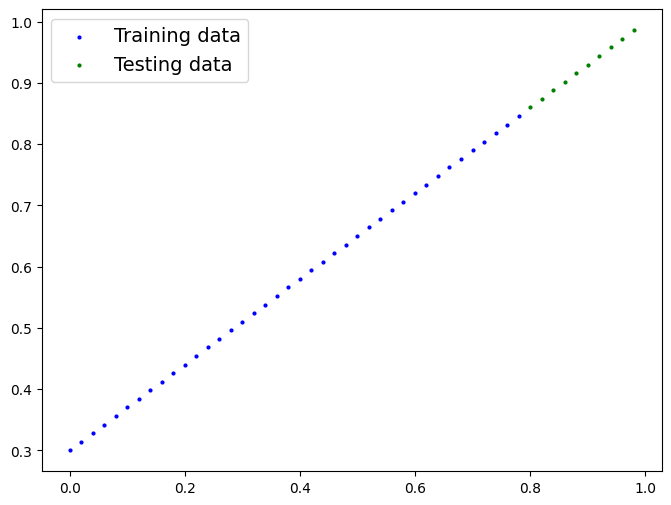

In [8]:
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [12]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    # This time we will work with layers
    # Use nn.Linear() for creating the model parameters/ also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, # beacuse we have one value of X(feature)
                                  out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x) #this will have the formula in itself

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelv2()
model_1, model_1.state_dict()

(LinearRegressionModelv2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [13]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [14]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [15]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [16]:
# setup a loss function and an optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01, )

In [18]:
torch.manual_seed(42)
epochs = 200

# Put all data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [19]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [20]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [21]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds_new = model_1(X_test)

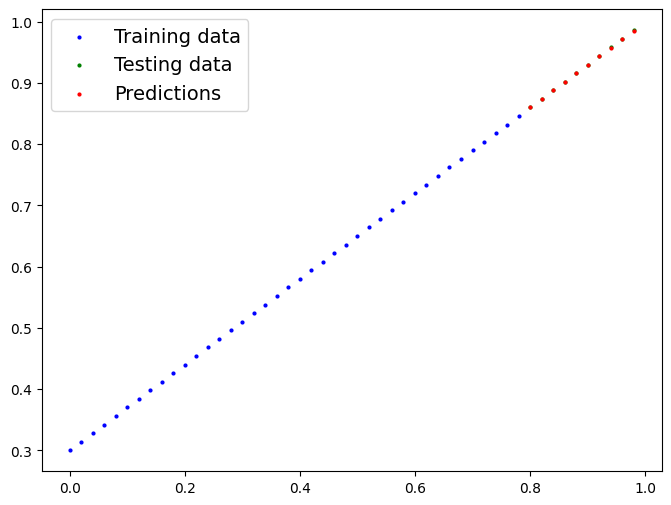

In [25]:
plot_predictions(predictions=y_preds_new.cpu()) # to plot the tensor had to be copied to the cpu yfirst to be loaded into the memory

### 6.5 Saving and loading the model

In [27]:
# saving the pyTorch model
from pathlib import Path

# 1. create a model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"#extension has to be either .pt or .pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

#save the model state dict - recommended
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

models/01_pytorch_workflow_model_0.pth
saving model to: models/01_pytorch_workflow_model_0.pth


In [28]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1744 Jun  1 06:38 01_pytorch_workflow_model_0.pth


## Loading a pyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [33]:
# to load in a saved state_dict we have to instantiate a new instanve of our model class
loaded_model_1 = LinearRegressionModelv2()
print(loaded_model_1.state_dict())

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to target devic
loaded_model_1.to(device)

OrderedDict([('linear_layer.weight', tensor([[-0.2343]])), ('linear_layer.bias', tensor([0.9186]))])


LinearRegressionModelv2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [34]:
print(loaded_model_1.state_dict()) # exact saved state_dict values

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])


In [35]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)
loaded_model_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [36]:
loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')